In [201]:
import numpy as np
import scipy.stats as st
import scipy.special as stFunc
import matplotlib.pyplot as plt
import pandas as pd

In [202]:
i = complex(0.0,1.0)

In [203]:
S0 = 100
K = 100
T = 1/365
r = 0.04
C = 1
G = 5
M = 5
Y = 1.8
q = 0

In [204]:
varPhi = lambda u: np.exp(T * C *stFunc.gamma(-Y)*( np.power(M-i*u,Y) - np.power(M,Y) + np.power(G+i*u,Y) - np.power(G,Y)))
omega = -1/T * np.log(varPhi(-i))

In [205]:
zeta1 = (r-q+omega)*T + C*T*stFunc.gamma(1-Y)*(M**(Y-1)-G**(Y-1))
zeta2 = C*T*stFunc.gamma(2-Y)*(M**(Y-2)+G**(Y-2))
zeta4 = C*stFunc.gamma(4-Y)*T*(M**(Y-4)+G**(Y-4))

In [206]:
L=8

In [207]:
a = (zeta1-L*np.sqrt(zeta2+np.sqrt(zeta4))).real
b = (zeta1+L*np.sqrt(zeta2+np.sqrt(zeta4))).real
# a = -L*np.sqrt(T)
# b = L*np.sqrt(T)

In [208]:
N = int(1e3)

In [209]:
L=150
# D=10
D = b-a
eta = D/N
h = L/N

u=np.linspace(-N/2*h,N/2*h,N)
x=np.linspace(-N/2*eta,N/2*eta,N)

# COS methodCDF

In [210]:
def COSDensity(cf,x,N,a,b):
    k = np.linspace(0,N-1,N)
    u = np.zeros([1,N])
    u = k * np.pi / (b-a)
    #F_k coefficients
    F_k = 2.0 / (b - a) * np.real(cf(u) * np.exp(-i * u * a));
    F_k[0] = F_k[0] * 0.5; # adjustment for the first term
    #Final calculation
    f_X = np.matmul(F_k , np.cos(np.outer(u, x - a )))
    # We output only the first row
    return f_X

In [211]:
x1 = np.linspace(-8,8,1000)

In [212]:
cF = lambda u: varPhi(u)

In [213]:
f_XExact = COSDensity(cF,x, 2**14, a,b)
f_fake = COSDensity(cF,x1, 2**14, a,b)

In [214]:
a,b =(x.shape[0]//4) ,(3*x.shape[0]//4)

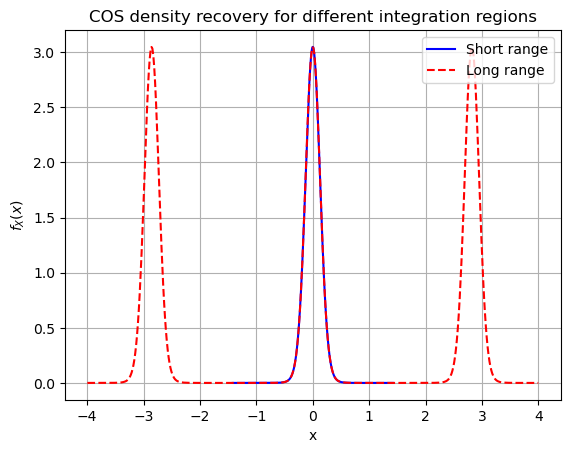

In [215]:
plt.figure()
plt.grid()
plt.title("COS density recovery for different integration regions")
plt.xlabel("x")
plt.ylabel("$f_X(x)$")
plt.plot(x,f_XExact,'b', label = 'Short range')
plt.plot(x1[a:b],f_fake[a:b],'--r', label = 'Long range')
plt.legend(loc = 'upper right')
plt.savefig("COS_CGMY_density")
plt.show()

In [216]:
dx = x[1]-x[0]
CDF1 = np.real(f_XExact).cumsum()*dx
# CDF1 = np.r_[np.array([0]), CDF1[:-1]]

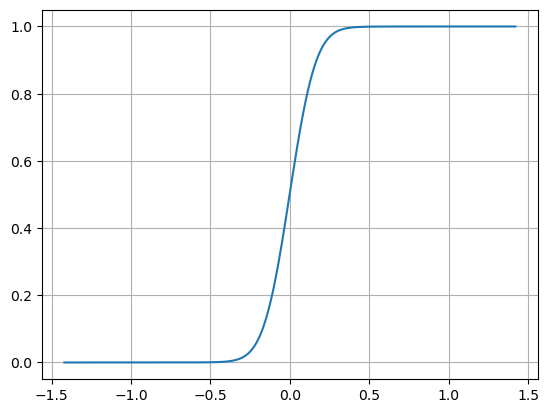

In [217]:
plt.plot(x,CDF1)
plt.grid()

# Ballota Kyriakou CDF

In [218]:
u=np.linspace(-N/2*h,N/2*h,N)
x=np.linspace(-N/2*eta,N/2*eta,N)

In [219]:
varPhi_r = -(1-np.cos(u*D))/i/u*varPhi(u)

In [220]:
CDF2=np.array([])
for l in range(N):
    F_l=0
    for j in range(N):
        F_l=F_l+np.exp(-i*u[j]*x[l])*varPhi_r[j]
    F_l = F_l * h/(2*np.pi)+0.5
    CDF2 = np.append(CDF2,F_l)
CDF2 = CDF2.real

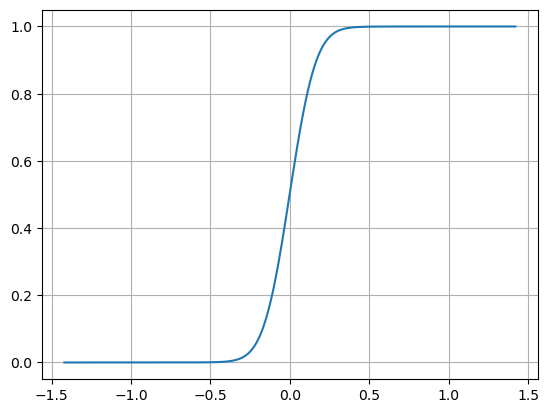

In [221]:
plt.plot(x, CDF1)
plt.grid()
plt.show()

In [222]:
error = (CDF1-CDF2)

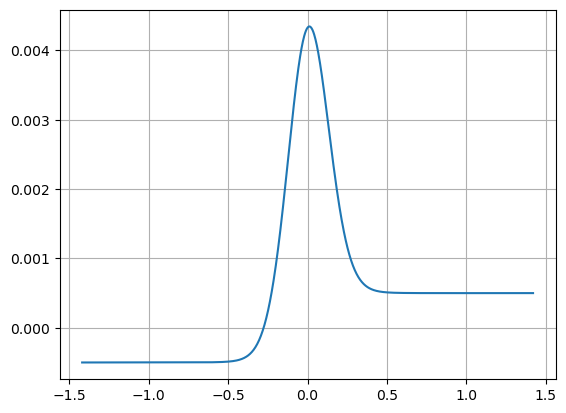

In [223]:
plt.plot(x, error )
plt.grid()
plt.show()

# Path sampling

#### CGMY 

In [224]:
seed = 1794

In [225]:
M = 365
time_grid = np.linspace(0,T,M)

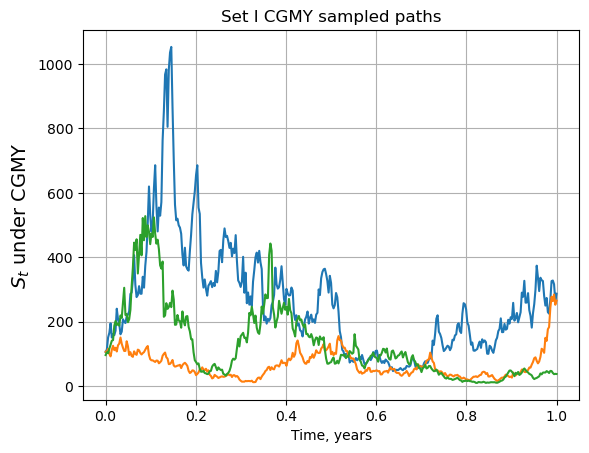

In [226]:
np.random.seed(1794)
u1 = np.random.random(int(M))
u2 = np.random.random(int(M))
u3 = np.random.random(int(M))

X1 = np.interp(u1,CDF2.real,x) + (r+omega)*T/12
X2 = np.interp(u2,CDF2.real,x) + (r+omega)*T/12
X3 = np.interp(u3,CDF2.real,x) + (r+omega)*T/12

time_grid = np.linspace(0,T*M,M)
X1 = X1.real.cumsum()
X2 = X2.real.cumsum()
X3 = X3.real.cumsum()

plt.plot(time_grid, S0*np.exp(X1))
plt.plot(time_grid, S0*np.exp(X2))
plt.plot(time_grid, S0*np.exp(X3))
plt.title('Set I CGMY sampled paths')
plt.grid(True)
plt.xlabel('Time, years')
plt.ylabel(r"$S_t$ under CGMY",fontsize=14)
plt.grid(True)
plt.savefig("CGMY1sampledPaths.png",bbox_inches='tight')
plt.show()

#### Variance Gamma

In [172]:
# SET 2
T = 1
M = 1000
theta = -0.14
sigma = 0.12
nu = 0.2

S0 = 100
r = 0.1
q = 0.0
dt = T/M

varPhi = lambda u: (1 - i * theta * nu * u + 0.5 * sigma**2 * nu * u**2) ** (-dt / nu)
omega = -1/dt * np.log(varPhi(-i))

mu = (omega + r-q).real # Drift parameter

def generateVG(T, M, mu, theta, sigma, nu):
    dt = T / M
    time_grid = np.linspace(0, T, M+1)
    
    gamma_increments = np.random.gamma(shape=dt/nu, scale=nu, size=M)
    z = np.random.normal(size=M)
    
    brownian_increments = sigma * np.sqrt(gamma_increments) * z
    
    vg_increments = mu * dt + theta * gamma_increments + brownian_increments
    
    vg_process = np.cumsum(vg_increments)
    vg_process = np.insert(vg_process, 0, 0)  # Include initial value
    
    return time_grid, vg_process

In [173]:
np.random.seed(794)
time_grid, vg_process1 = generateVG(T, M, mu, theta, sigma, nu)
time_grid, vg_process2 = generateVG(T, M, mu, theta, sigma, nu)
time_grid, vg_process3 = generateVG(T, M, mu, theta, sigma, nu)

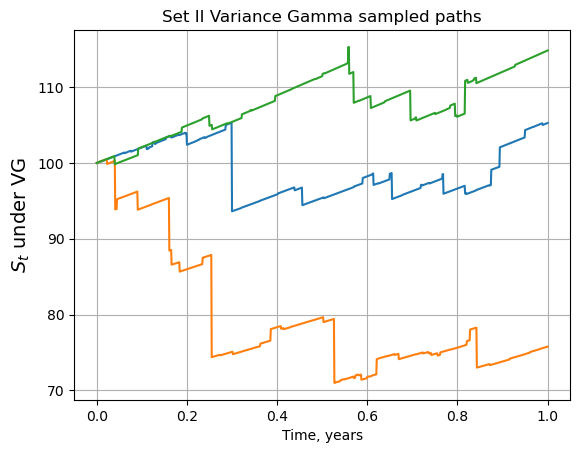

In [174]:
# Plot the result
plt.plot(time_grid, S0*np.exp(vg_process1))
plt.plot(time_grid, S0*np.exp(vg_process2))
plt.plot(time_grid, S0*np.exp(vg_process3))
plt.title('Set II Variance Gamma sampled paths')
plt.xlabel('Time, years')
plt.ylabel(r"$S_t$ under VG",fontsize=14)
plt.grid(True)
plt.savefig("VG2sampledPaths")
plt.show()

#### GBM

In [168]:
# Parameters
S0 = 100
r = 0.05
sigma = 0.2
T = 1.0
M = 1000

def generateGBM(r, sigma, T, M):    
    dt = T / M  # Time step
    time_grid = np.linspace(0, T, M)  # Time grid
    W_increments = np.random.normal(0, 1, M) * np.sqrt(dt)
    W_increments = np.cumsum(W_increments)
    
    gbm_process = (r - 0.5 * sigma**2) * time_grid + sigma * W_increments
    return time_grid, gbm_process

In [169]:
np.random.seed(seed)
time_grid, gbm_process1 = generateGBM(r, sigma, T, M)
time_grid, gbm_process2 = generateGBM(r, sigma, T, M)
time_grid, gbm_process3 = generateGBM(r, sigma, T, M)

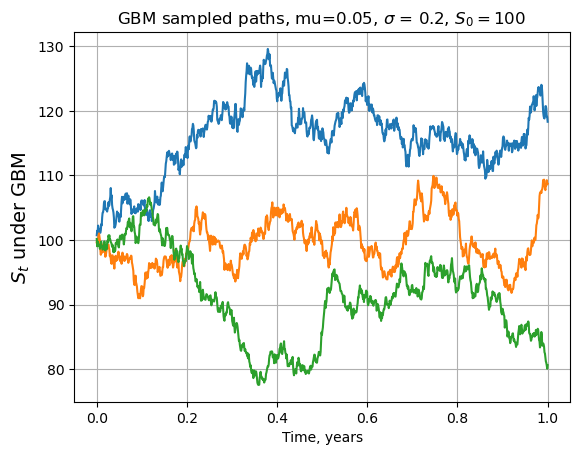

In [170]:
plt.plot(time_grid, S0*np.exp(gbm_process1))
plt.plot(time_grid, S0*np.exp(gbm_process2))
plt.plot(time_grid, S0*np.exp(gbm_process3))
plt.title(r'GBM sampled paths, mu=0.05, $\sigma$ = 0.2, $S_0=100$ ')
plt.xlabel('Time, years')
plt.ylabel(r"$S_t$ under GBM",fontsize=14)
plt.grid(True)
plt.savefig("GBMsampledPaths")
plt.show()